<a href="https://colab.research.google.com/github/CamiloRios11/SenalesySistemas2/blob/main/Correcci%C3%B3n_Parcial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pregunta 1:**

La distancia media entre dos señales periodicas $x_1(t) \in \mathbb{R}, \mathbb{C}$ y $x_2(t) \in \mathbb{R}, \mathbb{C}$; se puede expresar a partir de la potencia media de la diferencia entre ellas:
$$d^2(x_1, x_2) = \bar{P}_{x_1-x_2} = \lim_{T\to\infty} \frac{1}{T} \int_{T} |x_1(t) - x_2(t)|^2 dt.$$
Sea $x_1(t)$ y $x_2(t)$ dos señales definidas como:
$$x_1(t) = Ae^{-jnw_0t}$$
$$x_2(t) = Be^{jmw_0t}$$
con $w_0 = \frac{2\pi}{T}$; $T, A, B \in \mathbb{R}^+$ y $n, m \in \mathbb{Z}$. Determine la distancia entre las dos señales. Compruebe sus resultados con Python.

In [1]:
# ====== Paso 1: Cálculo simbólico con SymPy ======
import sympy as sp
import numpy as np

# Definición de símbolos
t, T = sp.symbols('t T', positive=True, real=True)
n, m = sp.symbols('n m', integer=True)
A, B = sp.symbols('A B')    # pueden ser complejos
w0 = 2*sp.pi/T

# Señales periódicas
x1 = A*sp.exp(-sp.I*n*w0*t)
x2 = B*sp.exp(+sp.I*m*w0*t)

# Distancia media cuadrada simbólica
# d² = |A|² + |B|² - 2·Re{A·B*}·δ_{n,-m}
d2_sym = sp.simplify(sp.Abs(A)**2 + sp.Abs(B)**2
                     - 2*sp.re(A*sp.conjugate(B))*sp.KroneckerDelta(n, -m))

# Convertimos a función numérica
d2_fun = sp.lambdify((A, B, n, m), d2_sym, 'numpy')


In [2]:
# Parámetros de las señales
T0 = 2.0
w0 = 2*np.pi/T0
A_val = 3.0 + 1.5j
B_val = 2.0 - 0.5j

# Definición de las señales en NumPy
def x1_np(t, A, n): return A*np.exp(-1j*n*w0*t)
def x2_np(t, B, m): return B*np.exp(+1j*m*w0*t)

# Cálculo numérico de d² = (1/T)∫|x1-x2|² dt usando una malla uniforme
def d2_numeric(A, B, n, m, T0, Ns=20001):
    t = np.linspace(0.0, T0, Ns, endpoint=False)
    dt = t[1] - t[0]
    diff = x1_np(t, A, n) - x2_np(t, B, m)
    return (np.abs(diff)**2).sum() * dt / T0


In [3]:
# Casos a evaluar: ortogonales y no ortogonales
casos = [(2, 3), (2, -2)]

for nn, mm in casos:
    d2_teo = d2_fun(A_val, B_val, nn, mm)
    d2_num = d2_numeric(A_val, B_val, nn, mm, T0)

    print("\n────────────────────────────────────────────")
    print(f" Caso con n = {nn}, m = {mm}")
    if nn + mm != 0:
        print("   ➤ Las señales son ORTOGONALES (frecuencias distintas).")
    else:
        print("   ➤ Las señales tienen FRECUENCIAS OPUESTAS (no ortogonales).")

    print(f"\n→ Resultado teórico (SymPy): d² = {d2_teo:.4f}")
    print(f"→ Resultado numérico (NumPy): d² = {d2_num:.4f}")
    print(f"→ Diferencia entre ambos resultados = {abs(d2_num - d2_teo):.2e}")

    print(f"\n→ Distancia teórica  d = {np.sqrt(d2_teo):.4f}")
    print(f"→ Distancia numérica d = {np.sqrt(d2_num):.4f}")
    print("────────────────────────────────────────────")


────────────────────────────────────────────
 Caso con n = 2, m = 3
   ➤ Las señales son ORTOGONALES (frecuencias distintas).

→ Resultado teórico (SymPy): d² = 15.5000
→ Resultado numérico (NumPy): d² = 15.5000
→ Diferencia entre ambos resultados = 1.78e-15

→ Distancia teórica  d = 3.9370
→ Distancia numérica d = 3.9370
────────────────────────────────────────────

────────────────────────────────────────────
 Caso con n = 2, m = -2
   ➤ Las señales tienen FRECUENCIAS OPUESTAS (no ortogonales).

→ Resultado teórico (SymPy): d² = 5.0000
→ Resultado numérico (NumPy): d² = 5.0000
→ Diferencia entre ambos resultados = 1.78e-15

→ Distancia teórica  d = 2.2361
→ Distancia numérica d = 2.2361
────────────────────────────────────────────


**Pregunta 2:**

Encuentre la señal en tiempo discreto al utilizar un conversor
analogo digital con frecuencia de muestreo de 5kHz y 4 bits
de capacidad de representacion, aplicado a la señal continua:

$x(t) = 3 cos(1000πt) + 5 sin(3000πt) + 10 cos(11000πt)$

Realizar la simulacion del proceso de discretizacion (incluyendo
al menos tres periodos de $x(t)$). En caso de que la discretizaci
on no sea apropiada, diseñe e implemente un conversor
adecuado para la señal estudiada.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# x(t) = 3 cos(1000π t) + 5 sin(3000π t) + 10 cos(11000π t)
def x_t(t):
    return 3*np.cos(1000*np.pi*t) + 5*np.sin(3000*np.pi*t) + 10*np.cos(11000*np.pi*t)

# Frecuencia/periodo fundamentales (500 Hz -> 2 ms)
f0 = 500.0
T0 = 1.0/f0

# Rango de visualización: 3 periodos
t_max = 3*T0
t_cont = np.linspace(0, t_max, 2000)   # “continua” de alta resolución
x_cont = x_t(t_cont)

# Rango para cuantización (amplitud pico <= 3+5+10 = 18)
vmin, vmax = -18.0, 18.0


**Señal con Aliasing**

In [5]:
#crear funcion en python
def my_ceropen(x,ymin = -5, ymax = 5): #en general se pueden definir valores por defecto
  '''
  Codigo base para simular proceso de cero y pendiente
  Se ingresa arreglo de numpy y los valores min  y max despues de cero y pendiente
  '''
  xmax = max(x) # x.max()
  xmin = min(x) # x.min()
  m = (ymax - ymin)/(xmax - xmin)
  c = ymin - m*xmin
  yv = m*x + c
  return yv

#función cuantización punto a punto

def my_cuantizador(yn, vq) : #yn punto a #cuantizar, vq vector de estados

  Ne = vq.shape[0] #tamaño vector de estados
  dn = cdist(yn.reshape(-1,1),vq.reshape(-1,1))#distancia yn a vector estados, reshape(-1,1) asegura vectores columna para poder utilizar cdist
  ind = np.argmin(dn) #posición distancia min
  return vq[ind]

Fs = 5000
Ts = 1/Fs
T = 1/500
t = np.arange(0,3*T,Ts)
w1 = 10000*np.pi
w2 = 3000*np.pi
w3 = 11000*np.pi
x = 3*np.cos(w1*t) + 5*np.sin(w2*t) + 10*np.cos(w3*t)


In [6]:
rmin = -5
rmax = 5
ycs = my_ceropen(x,ymin = rmin, ymax = rmax)

numb = 4

ve = np.linspace(rmin,rmax,2**numb)
for i in range(ycs.shape[0]):
  if i==0:
    yq = my_cuantizador(ycs[i],ve)
  else:
      yq = np.append(yq,my_cuantizador(ycs[i],ve))


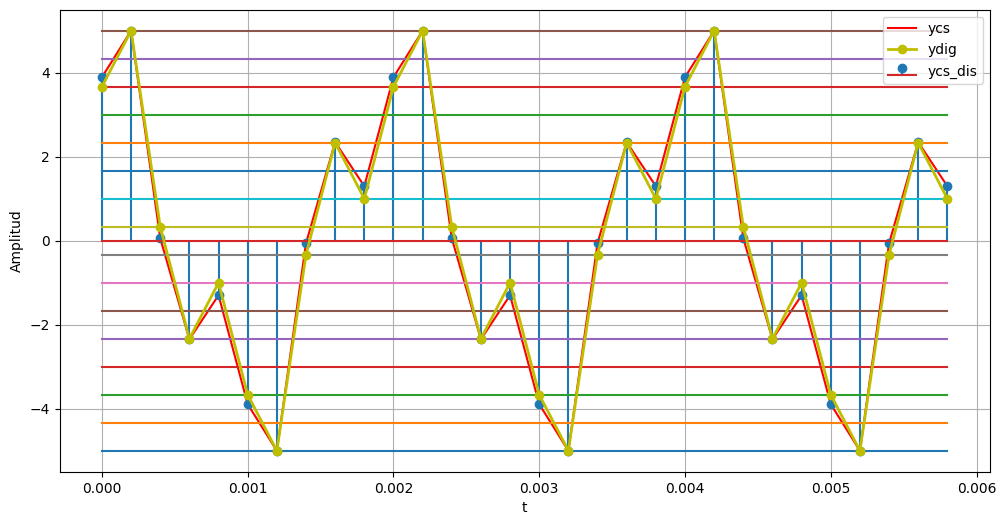

In [7]:
#graficar señales
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.plot(t,ycs,c='r', label='ycs')#cs continua

plt.stem(t,ycs, label='ycs_dis')#cs discreta

#estados de cuantización

for v in ve:
  plt.plot(t,v*np.ones(len(t)))

# graficar señal Digital (discreta + cuantizada)

plt.plot(t,yq,c='y',marker='o',label='ydig', linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('t')
plt.ylabel('Amplitud')
plt.show()


**Señal  Modificada**

In [8]:
# ========= Bloque 3: conversor ADECUADO (12 kHz, 8 bits) =========
fs_good   = 12_000.0
Ts_good   = 1.0/fs_good
bits_good = 4
L_good    = 2**bits_good
Δ_good    = (vmax - vmin)/L_good

t_good  = np.arange(0, t_max, Ts_good)
x_good  = x_t(t_good)
xq_good = Δ_good*np.round(x_good/Δ_good)

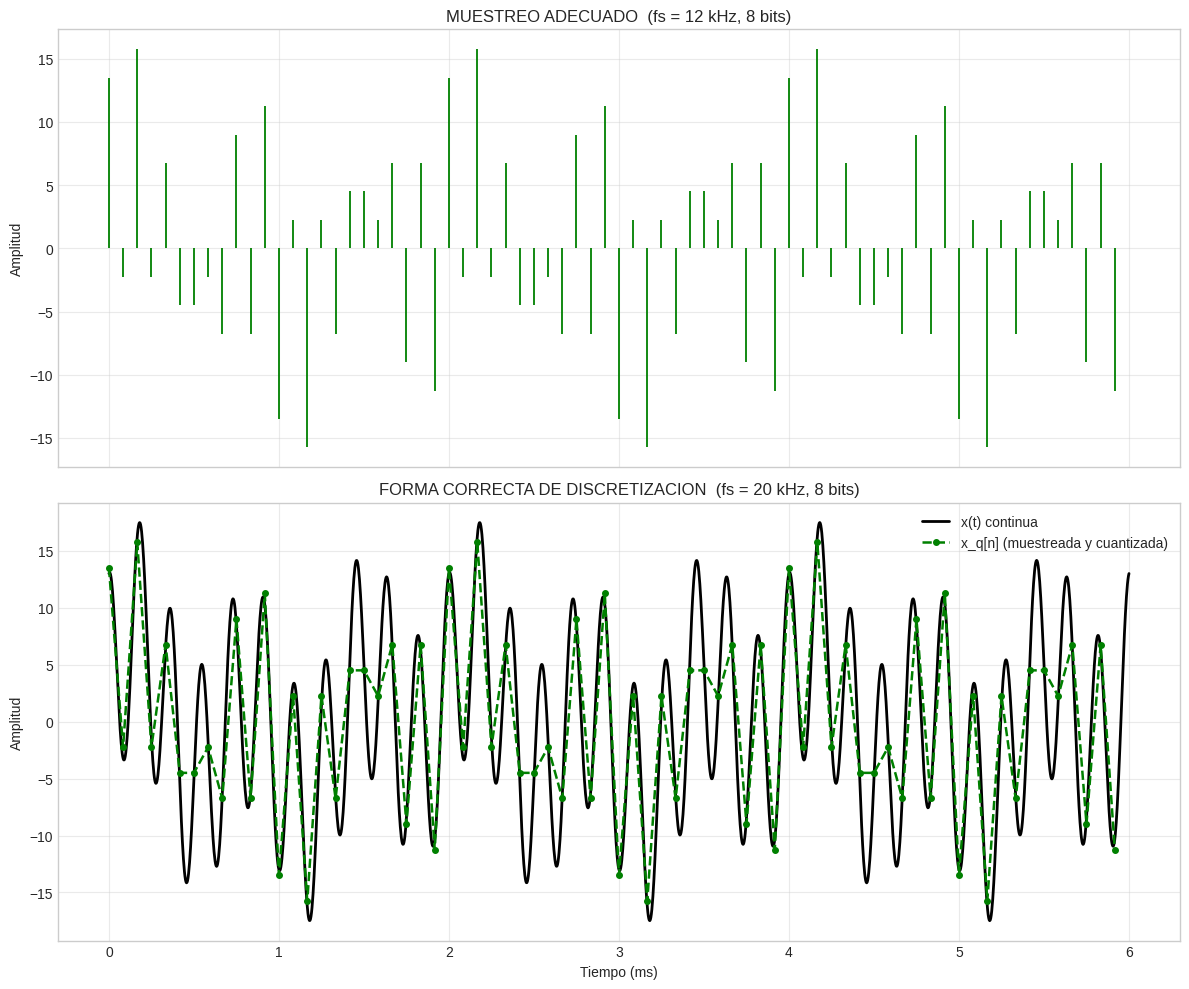

In [9]:
# ========= Bloque 4B: después de una buena discretización =========
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplots_adjust(hspace=0.4)  # separación entre gráficas

# --- (1) Solo discretización ADECUADA (pulsos tipo Dirac) ---
m2, s2, b2 = ax1.stem(t_good*1e3, xq_good, linefmt='g-', markerfmt=' ', basefmt=' ')
b2.set_visible(False)
plt.setp(s2, linewidth=1.3)
ax1.set_title('MUESTREO ADECUADO  (fs = 12 kHz, 8 bits)')
ax1.set_ylabel('Amplitud')
ax1.grid(True, alpha=0.4)

# --- (2) Comparativa: señal continua + discretización ADECUADA ---
ax2.plot(t_cont*1e3, x_cont, 'k-', lw=2, label='x(t) continua')
ax2.plot(t_good*1e3, xq_good, 'g--o', lw=1.8, markersize=4, label='x_q[n] (muestreada y cuantizada)')
ax2.set_title('FORMA CORRECTA DE DISCRETIZACION  (fs = 20 kHz, 8 bits)')
ax2.set_xlabel('Tiempo (ms)')
ax2.set_ylabel('Amplitud')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.4)

plt.tight_layout()
plt.show()


**Pregunta 4:**
Encuentre el espectro de Fourier, su parte real,
imaginaria, magnitud, fase y el error relativo para
$n∈{0,±1,±2,±3,±4,±5}$, a partir de $x′′(t)$ para la
señal $x(t)$ en la Figura 1 . Compruebe el espectro obtenido
con la estimacion a partir de $x(t)$. Presente las simulaciones
de Python respectivas.

In [10]:
# ====== Paso 1: Librerías y estilo ======
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [11]:
# ====== Paso 2: Parámetros generales ======
A  = 25.0           # amplitud
T  = 1e-2           # periodo [s] (10 ms)
Fo = 1/T            # frecuencia fundamental
Fs = 2000*Fo        # frecuencia de muestreo (>>Fo)
tv = np.arange(-T/2, T/2, 1/Fs)   # vector de tiempo dentro de un periodo
Nm = len(tv)

# puntos característicos (en segundos)
d2 = 2.0e-3           # fijo en 2 ms como en tu código
d1 = 1.3e-3           # > d2/2 para que el tramo externo sea más empinado

In [12]:
# ====== Paso 3: Construir señal x(t) ======
x = np.zeros_like(tv)

# Tramos vectorizados
idx1 = (tv >= -d2) & (tv < -d1)
x[idx1] = (A/(d2 - d1))*(tv[idx1] + d2)

idx2 = (tv >= -d1) & (tv < 0)
x[idx2] = (-A/d1)*tv[idx2]

idx3 = (tv >= 0) & (tv < d1)
x[idx3] = (A/d1)*tv[idx3]

idx4 = (tv >= d1) & (tv < d2)
x[idx4] = (-A/(d2 - d1))*(tv[idx4] - d1) + A

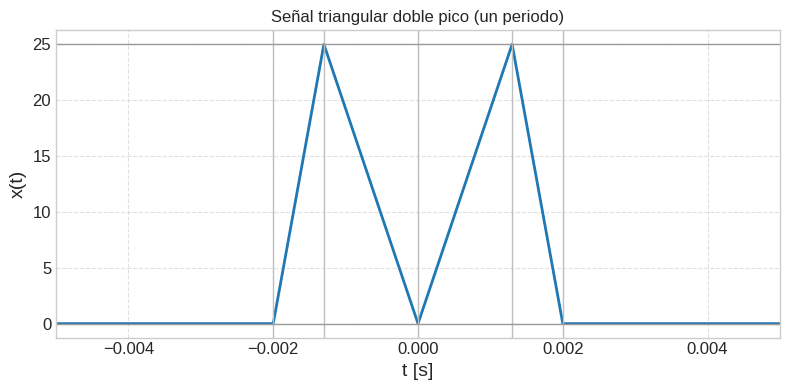

In [13]:
# ====== Paso 4: Graficar la señal ======
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(tv, x, 'C0', linewidth=2, label='$x(t)$')

# líneas guía
for tmark in [-d2, -d1, 0, d1, d2]:
    ax.axvline(tmark, color='0.75', lw=1)
ax.axhline(0, color='0.6', lw=1)
ax.axhline(A, color='0.6', lw=1)

ax.set_xlim(-T/2, T/2)
ax.set_xlabel('t [s]')
ax.set_ylabel('x(t)')
ax.set_title('Señal triangular doble pico (un periodo)')
ax.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [14]:
# ====== Paso 5: Definir bases complejas ======
N  = 10                       # número de armónicos por lado
wo = 2*np.pi/T
nv = np.arange(-N, N+1)       # índices n
phin = np.exp(1j*np.outer(tv, nv*wo))   # matriz Nm x (2N+1)

In [15]:
# ====== Paso 6: Coeficientes Cn ======
Cn = np.zeros(2*N+1, dtype=np.float64)  # ahora serán reales
for k, n in enumerate(nv):
    if n == 0:
        Cn[k] = (1/T) * np.trapezoid(x, tv)
    else:
        Cn[k] = (1/T) * np.trapezoid(x * np.cos(n*wo*tv), tv)


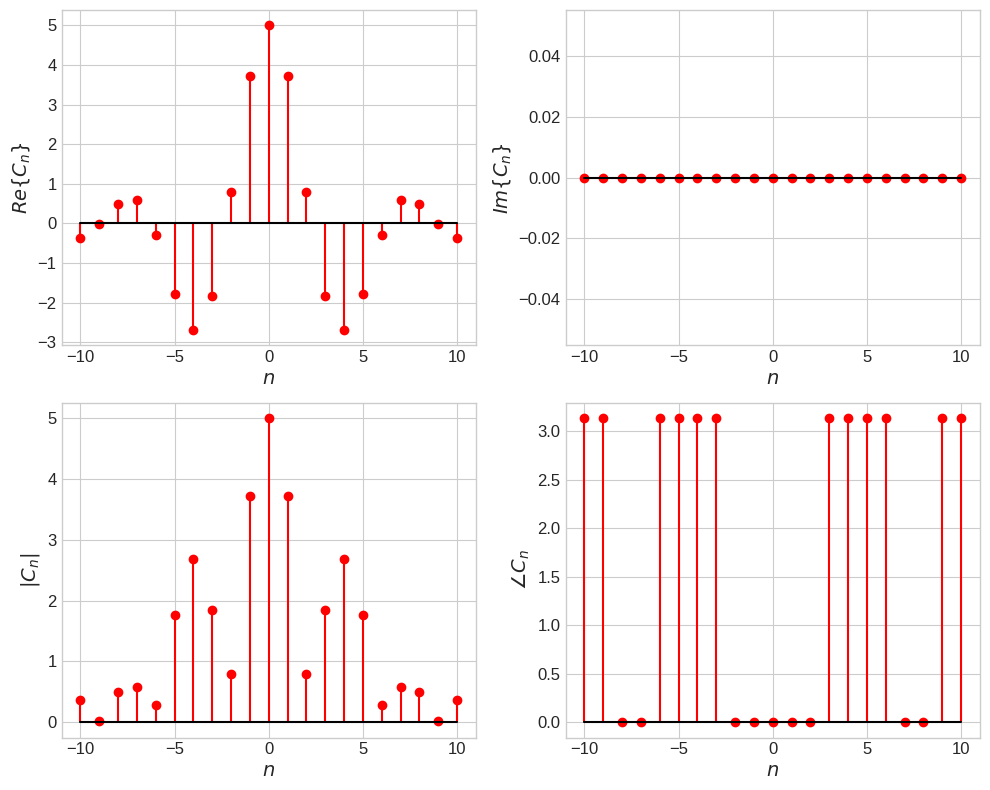

In [16]:
# ====== Paso 7: Graficar espectro ======
fig = plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.stem(nv, np.real(Cn), 'r', basefmt='k')
plt.xlabel(r'$n$'); plt.ylabel(r'$Re\{C_n\}$'); plt.grid(True)

plt.subplot(2,2,2)
plt.stem(nv, np.imag(Cn), 'r', basefmt='k')
plt.xlabel(r'$n$'); plt.ylabel(r'$Im\{C_n\}$'); plt.grid(True)

plt.subplot(2,2,3)
plt.stem(nv, np.abs(Cn), 'r', basefmt='k')
plt.xlabel(r'$n$'); plt.ylabel(r'$|C_n|$'); plt.grid(True)

plt.subplot(2,2,4)
plt.stem(nv, np.angle(Cn), 'r', basefmt='k')
plt.xlabel(r'$n$'); plt.ylabel(r'$\angle C_n$'); plt.grid(True)

plt.tight_layout()
plt.show()

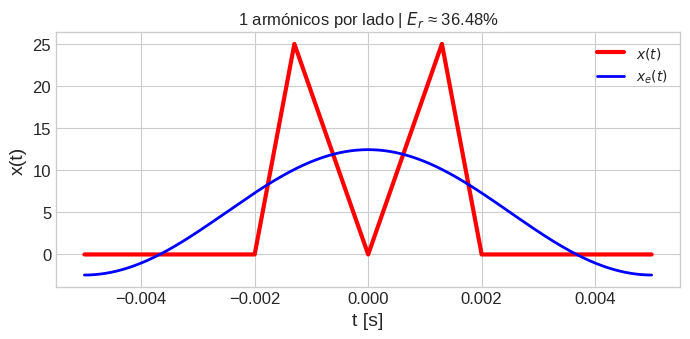

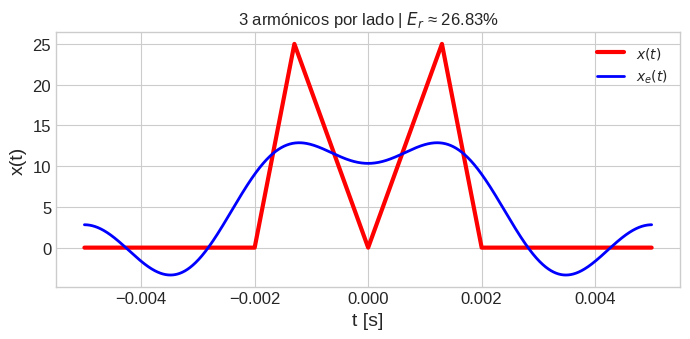

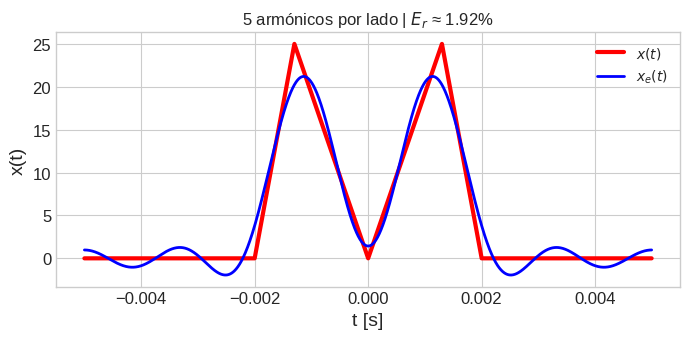

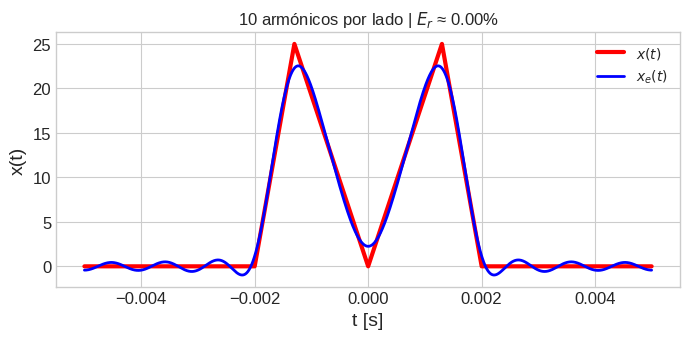

In [17]:
# ====== Paso 8: Reconstrucción y error ======
Px = np.sum(np.abs(Cn)**2)

def reconstruccion(Na):
    """Reconstrucción con Na armónicos por lado."""
    ind = np.arange(N-Na, N+Na+1)
    C_use = Cn[ind]
    x_est = phin[:, ind] @ C_use
    Er = 1 - np.sum(np.abs(C_use)**2)/Px
    return x_est, Er

# Ejemplo: probar con algunos Na
for Na in [1, 3, 5, 10]:
    xe, Er = reconstruccion(min(Na, N))
    plt.figure(figsize=(7,3.5))
    plt.plot(tv, x, 'r', lw=3, label='$x(t)$')
    plt.plot(tv, np.real(xe), 'b', lw=2, label='$x_e(t)$')
    plt.title(f'{Na} armónicos por lado | $E_r$ ≈ {100*Er:.2f}%')
    plt.xlabel('t [s]')
    plt.ylabel('x(t)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

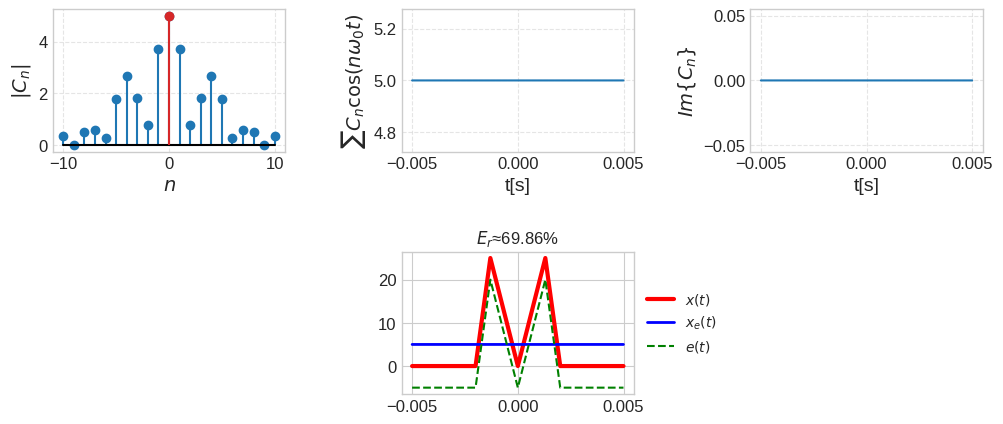

In [18]:
# ====== Paso 9: Animación de reconstrucción ======

phi_cos = np.cos(np.outer(tv, nv*wo))   # Nm x (2N+1)

figA, axA = plt.subplots(2, 3, figsize=(12,5))

def update(n):
    for a in axA.flat:
        a.clear()
    Na  = n
    ind = np.arange(N-Na, N+Na+1)    # usamos ±n como antes
    C_use = Cn[ind]

    # Reconstrucción con cosenos (TODO real)
    xe = phi_cos[:, ind] @ C_use           # Nm x k  @ k -> Nm
    ce = phi_cos[:, ind] * C_use           # componentes espectrales (t,k)

    # Espectro: magnitud de Cn (ahora son reales)
    axA[0,0].stem(nv, np.abs(Cn), basefmt='k')
    axA[0,0].stem(nv[ind], np.abs(C_use), linefmt='C3-', markerfmt='C3o', basefmt='k')
    axA[0,0].set_xlabel(r'$n$'); axA[0,0].set_ylabel(r'$|C_n|$');
    axA[0,0].grid(True, ls='--', alpha=0.5)

    # Componentes en el tiempo:
    # Real: suma de Cn*cos(nw0t); Imaginario = 0 EXACTO
    axA[0,1].plot(tv, ce.sum(axis=1))
    axA[0,1].set_xlabel('t[s]'); axA[0,1].set_ylabel(r'$\sum C_n\cos(n\omega_0 t)$')
    axA[0,1].grid(True, ls='--', alpha=0.5)

    axA[0,2].plot(tv, np.zeros_like(tv))        # cero exacto
    axA[0,2].set_xlabel('t[s]'); axA[0,2].set_ylabel(r'$Im\{C_n\}$')
    axA[0,2].grid(True, ls='--', alpha=0.5)

    # Reconstrucción y error de energía (Parseval con Cn reales)
    Et = x - xe
    Er = 1 - np.sum(np.abs(C_use)**2)/Px        # Px ya calculado con los Cn
    axA[1,1].plot(tv, x,  'r', lw=3, label='$x(t)$')
    axA[1,1].plot(tv, xe, 'b', lw=2, label='$x_e(t)$')
    axA[1,1].plot(tv, Et, 'g--', label='$e(t)$')
    axA[1,1].set_title(f'$E_r$≈{100*Er:.2f}%')
    axA[1,1].legend(loc='center left', bbox_to_anchor=(1,0.5))

    axA[1,0].axis('off'); axA[1,2].axis('off')
    plt.subplots_adjust(wspace=0.5,hspace=0.7)

anim = animation.FuncAnimation(figA, update, frames=np.arange(0, N+1, 1), blit=False)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())
